# Ejercicio 1

In [ ]:
# Organizar los datos adecuadamente
dosis <- c(1, 2, 4, 8, 16, 32)
logdosis <- log2(dosis)
machosd <- c(1, 4, 9, 13, 18, 20)
hembrasd <- c(0, 2, 6, 10, 12, 16)
n <- 20 # orugas por grupo

datos <- data.frame(
  dosis = rep(dosis, 2),
  logdosis = rep(logdosis, 2),
  muertos = c(machosd, hembrasd),
  vivos = n - c(machosd, hembrasd),
  sexo = factor(rep(c(0, 1), each = length(dosis)), labels = c("macho", "hembra"))
)

datos

dosis,logdosis,muertos,vivos,sexo
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0,1,19,macho
2,1,4,16,macho
4,2,9,11,macho
8,3,13,7,macho
16,4,18,2,macho
32,5,20,0,macho
1,0,0,20,hembra
2,1,2,18,hembra
4,2,6,14,hembra


# b) Ajustar GLM


In [ ]:
# Ajustar un modelo lineal generalizado de familia binomial
Y = cbind(datos$muertos, datos$vivos) # Matriz resultados con clumnas (exito, fracaso)
modelo <- glm(Y ~ sexo*logdosis, family = binomial, data = datos)
summary(modelo)
model.matrix(modelo)


Call:
glm(formula = Y ~ sexo * logdosis, family = binomial, data = datos)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -2.8186     0.5480  -5.143 2.70e-07 ***
sexohembra           -0.1750     0.7783  -0.225    0.822    
logdosis              1.2589     0.2121   5.937 2.91e-09 ***
sexohembra:logdosis  -0.3529     0.2700  -1.307    0.191    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 124.8756  on 11  degrees of freedom
Residual deviance:   4.9937  on  8  degrees of freedom
AIC: 43.104

Number of Fisher Scoring iterations: 4


,(Intercept),sexohembra,logdosis,sexohembra:logdosis
1,1,0,0,0
2,1,0,1,0
3,1,0,2,0
4,1,0,3,0
5,1,0,4,0
6,1,0,5,0
7,1,1,0,0
8,1,1,1,1
9,1,1,2,2
10,1,1,3,3


El coeficiente para logdosis es 1.2589,  por cada aumento unitario en el logaritmo de la dosis, el logit de la probabilidad de muerte aumenta en 1.2589. Este coeficiente es altamente significativo (𝑝=2.91𝑒^−09), lo que indica una fuerte relacion positiva entre la dosis y la probabilidad de muerte. Es decir a medida que la dosis aumenta la probabilidad de muerte tambien aumenta.

Por otro lado, no hay evidencia suficiente para afirmar que el sexo del afecta la probabilidad de muerte, ni de que la relacion entre dosis y la probabilidad de muerte varia significativamente entre sexo.

# a) Determinar parametros


In [ ]:
# Calcular los parametros del modelo generalizado
p <- predict(modelo, type = "response")
mu <- n*p

# theta
theta <- log(mu/(n - mu))
# phi
phi = 1
# a(phi)
a <- 1
# b(theta)
b <- n*log(1 + exp(theta))
# c(y,phi)
c <- log(choose(n, Y))
# Liga canonica g_c(mu)
g <- mu/(n - mu)
# Valor esperado E(Y)
E <- mu
# Varianza Var(Y)
V <- mu*(1 - mu/n)

P <- list(theta, phi, a, b, c, g, E, V)
print(P)

[[1]]
         1          2          3          4          5          6          7 
-2.8185550 -1.5596055 -0.3006561  0.9582933  2.2172427  3.4761922 -2.9935418 
         8          9         10         11         12 
-2.0875053 -1.1814689 -0.2754324  0.6306040  1.5366404 

[[2]]
[1] 1

[[3]]
[1] 1

[[4]]
         1          2          3          4          5          6          7 
 1.1595686  3.8160263 11.0815216 25.6588749 46.4123873 70.1329711  0.9778917 
         8          9         10         11         12 
 2.3378053  5.3520521 11.2976802 21.1470885 34.6293779 

[[5]]
           [,1]      [,2]
 [1,]  2.995732  2.995732
 [2,]  8.485703  8.485703
 [3,] 12.031481 12.031481
 [4,] 11.258291 11.258291
 [5,]  5.247024  5.247024
 [6,]  0.000000  0.000000
 [7,]  0.000000  0.000000
 [8,]  5.247024  5.247024
 [9,] 10.565144 10.565144
[10,] 12.126791 12.126791
[11,] 11.743799 11.743799
[12,]  8.485703  8.485703

[[6]]
          1           2           3           4           5           6 


# c) Metodo Fisher Scoring

In [ ]:
# Inicializando variables necesarias
beta <- c(-1, 0, 0, 0)
X <- model.matrix(modelo)
tol <- 1e-4
nmax <- 100
it <- 0
error <- 10

while((error > tol)&(it < nmax)) {
  it <- it +1

  # Parametros eta y mu
  eta <- as.vector(X %*% beta)
  m <- as.vector(n*exp(eta)/(1 + exp(eta)))

  # Calcular g'(mu) y varianza
  dg <- as.vector(n/(n - m)^2)
  v <- as.vector(m*(1 - m/n))

  # Calcular matriz de pesos
  D <- diag(1/dg)
  W <- diag(1/v)
  U <- D %*% W %*% D

  y <- eta + solve(D) %*% (Y[,1] - m)

  beta_k <- solve(t(X) %*% U %*% X) %*% t(X) %*% U %*% y
  error <- sqrt(sum((beta - beta_k)^2))
  beta <- beta_k
}
beta
R = sqrt((beta-coef(modelo))^2)
R

(Intercept),-2.8618123
sexohembra,-1.6253827
logdosis,1.3285516
sexohembra:logdosis,0.5536857


(Intercept),0.04325733
sexohembra,1.45039587
logdosis,0.06960218
sexohembra:logdosis,0.90659868


Los coeficientes para el intercepto y para logdosis se acercan ligeramente a los valores obtenidos con GLM, sin embargo el error para los demas coeficientes es muy alto.

# d) Grafica

dosis,logdosis,muertos,vivos,sexo,pred,est
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
1,0,1,19,macho,0.05632970,1.1265939
2,1,4,16,macho,0.17370326,3.4740651
4,2,9,11,macho,0.42539710,8.5079419
8,3,13,7,macho,0.72277997,14.4555993
16,4,18,2,macho,0.90178726,18.0357453
32,5,20,0,macho,0.97000272,19.4000544
1,0,0,20,hembra,0.04771849,0.9543698
2,1,2,18,hembra,0.11031718,2.2063437
4,2,6,14,hembra,0.23478819,4.6957638


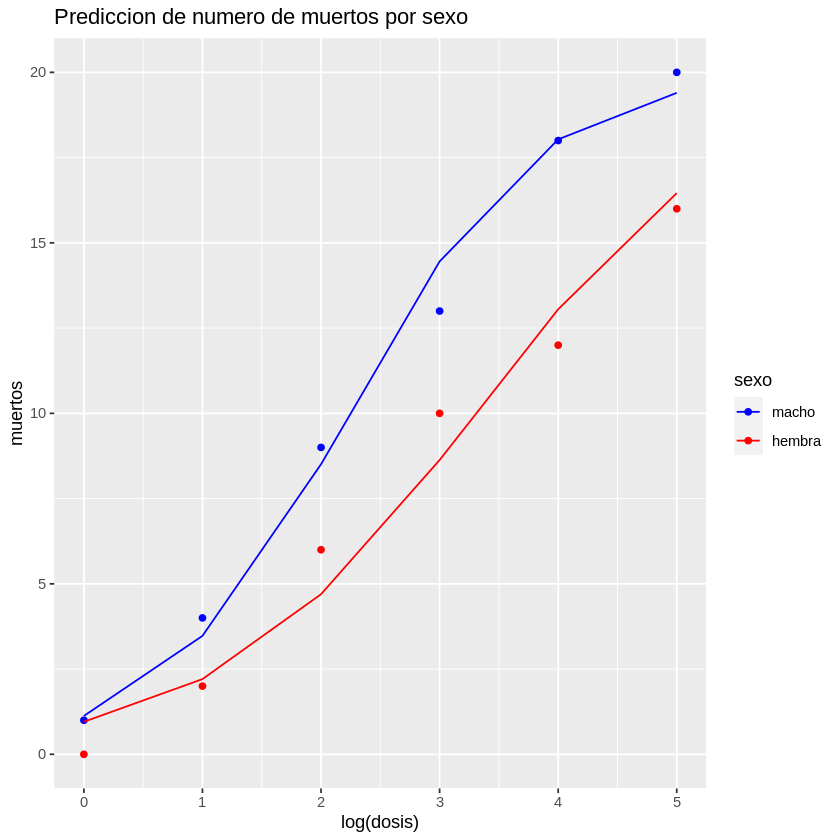

In [ ]:
library(ggplot2)
# Obtener los valores de la prediccion para la curva
datos$pred <- p
datos$est <- n*p
datos

ggplot(datos, aes(x = logdosis, y = muertos, color = sexo)) +
  geom_point() +  # Datos observados
  geom_line(aes(y = est)) +  # Curvas estimadas
  scale_color_manual(values = c("macho" = "blue", "hembra" = "red")) +
  labs(title = "Prediccion de numero de muertos por sexo",
       x = "log(dosis)", y = "muertos")

# Ejercicio 2

Para la relacion entre el tipo de tumor y su localización utilizando un modelo lineal generalizado, en este caso, como el tipo de tumor y la localización son variables categoricas, podemos aplicar un modelo log-lineal para evaluar la asociacion entre estas variables.

In [ ]:
# Definir la tabla de datos
tabla <- matrix(c(
      22, 2, 10,   # Hutchinson's melanotic freckle
      16, 54, 115, # Superficial spreading melanoma
      19, 33, 73,  # Nodular
      11, 17, 28   # Indeterminate
  ), nrow = 4, byrow = TRUE)

colnames(tabla) <- c("Head & neck", "Trunk", "Extremities")
rownames(tabla) <- c("Hutchinson's melanotic freckle", "Superficial spreading melanoma",
                    "Nodular", "Indeterminate")
tabla

# Convertir la tabla en un data frame
tumor_type <- factor(rep(rownames(tabla), each = 3))
site <- factor(rep(colnames(tabla), times = 4))
counts <- as.vector(t(tabla))
datos2 <- data.frame(tumor_type, site, counts)
datos2

Ajustar un modelo de regresion Poisson usando GLM, donde el modelo toma la cantidad de tumores observados con respecto a la interaccion entre tipo y localizacion.

In [ ]:
# Renombramos los niveles de los factores para facilitar la lectura
colnames(tabla) <- c("SiteA", #Head & neck
                     "SiteB", #Trunk
                     "SiteC") #Extremities
rownames(tabla) <- c("Type1", #Hutchinson's melanotic freckle
                     "Type2", #Superficial spreading melanoma
                     "Type3", #Nodular
                     "Type4") #Indeterminate
tumor_type <- factor(rep(rownames(tabla), each = 3))
site <- factor(rep(colnames(tabla), times = 4))
counts <- as.vector(t(tabla))
datos2 <- data.frame(tumor_type, site, counts)
datos2

modelo2 <- glm(counts ~ tumor_type*site, family = poisson, data = datos2)
summary(modelo2)

En los resultados obtenemos que los efectos de los tipos de tumor por si solos nos son significativos, sin embargo los efectos de la localizacion en comparacion con la localizacion A (Head & neck) si lo son.
Para el problema en cuestion, podemos ver que todos los coeficientes de las interacciones son positivos y altamente significativos, con p-value mucho menores que 0.001.

In [ ]:
# Reordenar las categorias para ver interacciones de el sitio A (Head & neck) y el tipo 1 (Hutchinson's melanotic freckle)
#datos2$tumor_type <- relevel(datos2$tumor_type, ref = "Type4")
datos2$site <- relevel(datos2$site, ref = "SiteC")

modelo3 <- glm(counts ~ tumor_type*site, family = poisson, data = datos2)
summary(modelo3)

Ahora observamos que los efectos de los tipos de tumores, por si solos, si tienen efectos significativos, ademas de los sitios y las interacciones, contando con p-value mucho menores a 0.05.

Todos los resultados indican que hay interacciones significativas entre ciertos tipos y ciertas localizaciones, lo que sugiere una asociacion entre el tipo de tumor y su localizacion.

Del primer modelo:
* "Type2" (Superficial spreading melanoma) muestra una interaccion altamente significativa con "SiteB" (Trunk) y "SiteC" (Extremities).
* "Type3" (Nodular) tambien muestra una interaccion muy significativa con "SiteB" (Trunk) y "SiteC" (Extremities).
* "Type4" (Indeterminate) muestra una interaccion importante con  "SiteB" (Trunk) y "SiteC" (Extremities).

Esos coeficientes indican un aumento significativo en el logaritmo de los conteos esperados para estas combinaciones.

* "SiteA" (Head & neck) tiene un impacto importante en el tumor "Type4" (Indeterminate), mostrando una disminución significativa en el logaritmo de los conteos esperados en comparación con "SiteC" (Extremities).

Del segundo modelo:
* "Type1" (Hutchinson's melanotic freckle) muestra una interaccion significativa con "SiteA" (Head & neck).
* "Type2" (Superficial spreading melanoma) y "Type3" (Nodular) muestran interacciones significativas con "SiteA" (Head & neck), en direcciones opuestas.

La localizacion del tumor tiene un impacto muy importante en los tipos de tumores, especialmente en la comparacion de "SiteA" con "SiteC".
Estos hallazgos implican que la distribucion del tipo de tumor varia dependiendo de la localizacion del tumor, lo cual tiene consecuencias importantes para la epidemiología del melanoma maligno y su tratamiento.